<a href="https://colab.research.google.com/github/harshit-kr-dubey/Airports-Data---ETL-Pipeline---Exploratory-Data-Analysis/blob/main/airport_data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6393 entries, 0 to 6392
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AirportName         6393 non-null   object 
 1   IATA                6373 non-null   object 
 2   ICAO                5091 non-null   object 
 3   TimeZone            6305 non-null   object 
 4   City_Name           6393 non-null   object 
 5   City_IATA           6331 non-null   object 
 6   UTC_Offset_Hours    6305 non-null   float64
 7   UTC_Offset_Seconds  6305 non-null   float64
 8   Country_CodeA2      6379 non-null   object 
 9   Country_CodeA3      6393 non-null   object 
 10  Country_Name        6393 non-null   object 
 11  GeoPointLat         6393 non-null   float64
 12  GeoPointLong        6393 non-null   float64
dtypes: float64(4), object(9)
memory usage: 649.4+ KB
None

Data Description:
       UTC_Offset_Hours  UTC_Offset_Seconds  GeoPointLat  GeoPointLo

/tmp/ipython-input-6-3374141286.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transformed['IATA'].fillna('UNK', inplace=True)
/tmp/ipython-input-6-3374141286.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

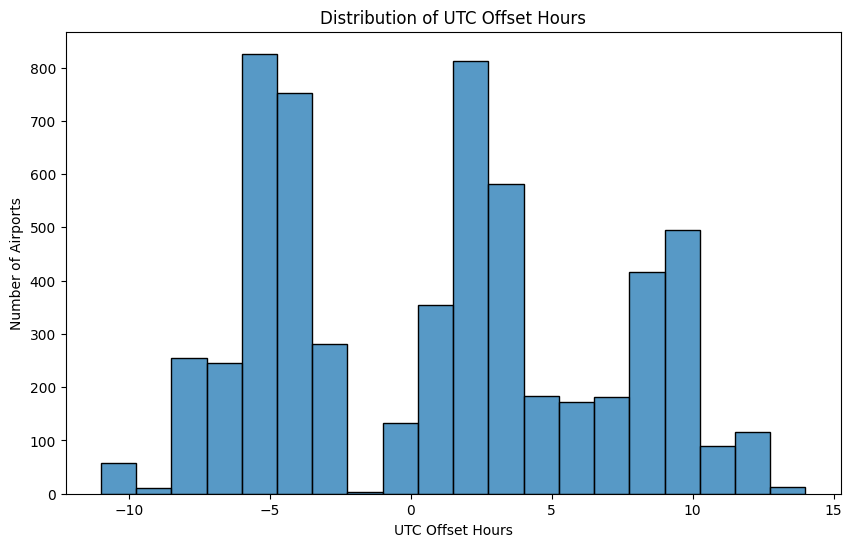

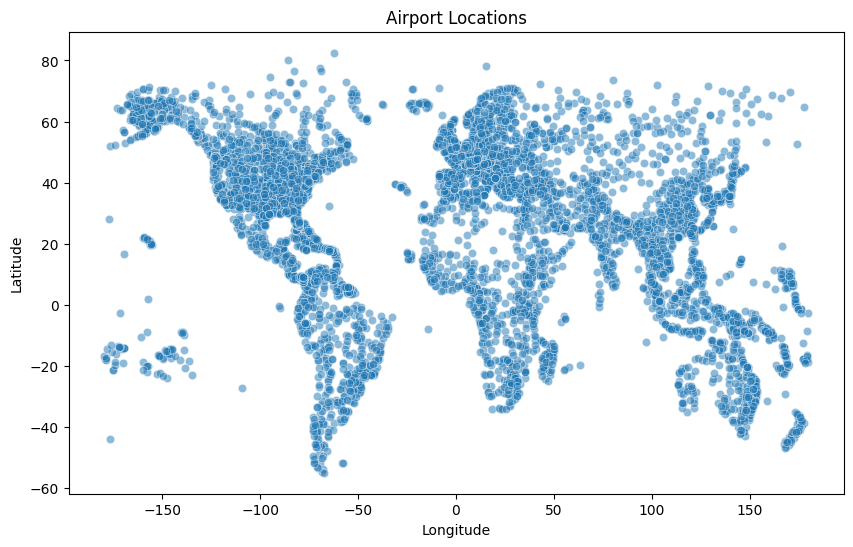

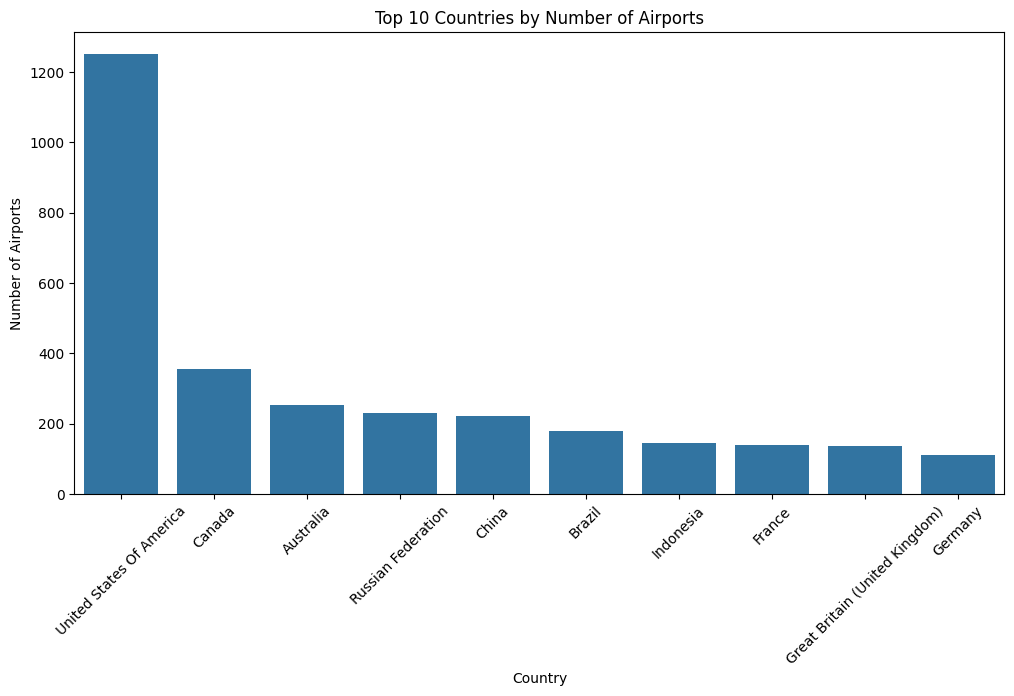

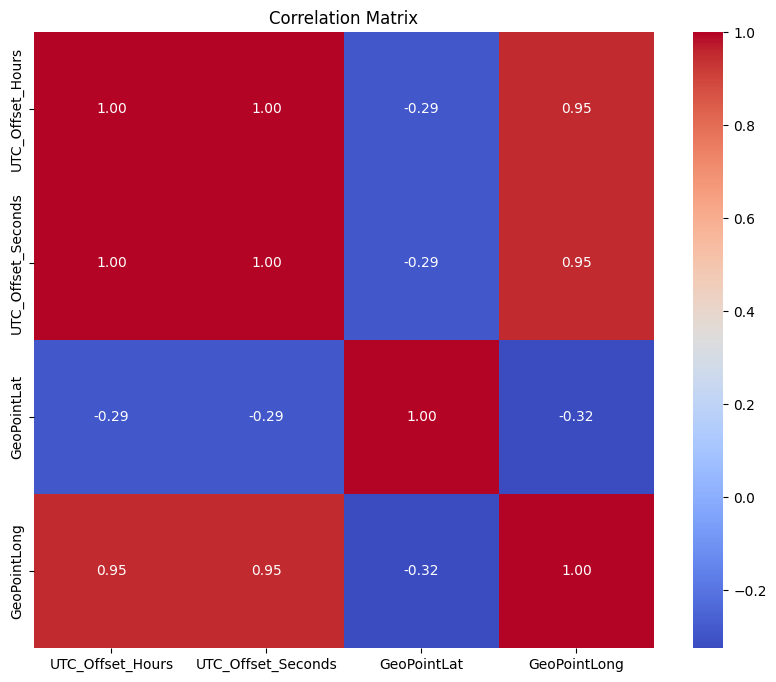

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.DEBUG)

# Step 1: Extract data from a CSV file
def extract(filepath):
    """Extract data from the specified CSV file"""
    try:
        df = pd.read_csv(filepath)
        logging.debug(f'{filepath} has been extracted')
        logging.info(f'There are {df.shape[0]} rows and {df.shape[1]} columns')
        print("\nData Info:")
        print(df.info())
        print("\nData Description:")
        print(df.describe())
        print("\nFirst 5 Rows:")
        print(df.head())
        return df
    except Exception as e:
        logging.error(f"Error extracting data: {str(e)}")
        return None

# Step 2: Transform data
def transform(df):
    """Transform the airport data by cleaning and standardizing"""
    required_cols = ['IATA', 'ICAO', 'AirportName', 'Country_Name', 'City_Name',
                     'UTC_Offset_Hours', 'UTC_Offset_Seconds', 'GeoPointLat', 'GeoPointLong']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        logging.error(f"Error: Missing columns in the dataset: {missing_cols}")
        return None

    df_transformed = df.copy()
    df_transformed = df_transformed.drop_duplicates(subset=['IATA'], keep='first')

    df_transformed.replace(['', 'No information'], np.nan, inplace=True)
    df_transformed['IATA'].fillna('UNK', inplace=True)
    df_transformed['ICAO'].fillna('UNKNOWN', inplace=True)
    df_transformed['City_Name'].fillna(df_transformed['AirportName'], inplace=True)
    df_transformed['GeoPointLat'].fillna(0, inplace=True)
    df_transformed['GeoPointLong'].fillna(0, inplace=True)

    numeric_cols = ['UTC_Offset_Hours', 'UTC_Offset_Seconds', 'GeoPointLat', 'GeoPointLong']
    for col in numeric_cols:
        df_transformed[col] = pd.to_numeric(df_transformed[col], errors='coerce')

    df_transformed = df_transformed[~((df_transformed['GeoPointLat'] == 0.0) &
                                      (df_transformed['GeoPointLong'] == 0.0))]

    for col in ['Country_Name', 'City_Name', 'AirportName']:
        df_transformed[col] = df_transformed[col].str.strip().str.title()

    df_transformed['Hemisphere'] = df_transformed['GeoPointLat'].apply(
        lambda x: 'Northern' if x > 0 else 'Southern' if x < 0 else 'Equator'
    )

    df_transformed.sort_values(['Country_Name', 'AirportName'], inplace=True)
    return df_transformed

# Step 3: Load dataframe into a SQL database and save to CSV
def load(dataframe, csv_path, db_path, table_name):
    dataframe.to_csv(csv_path, index=False)
    logging.info(f"Transformed data saved to {csv_path}")

    conn = sqlite3.connect(db_path)
    dataframe.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()
    logging.info(f"Data loaded into SQLite DB at {db_path}, table {table_name}")

# Step 4: EDA
def exploratory_data_analysis(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['UTC_Offset_Hours'].dropna(), bins=20, kde=False)
    plt.title('Distribution of UTC Offset Hours')
    plt.xlabel('UTC Offset Hours')
    plt.ylabel('Number of Airports')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='GeoPointLong', y='GeoPointLat', alpha=0.5)
    plt.title('Airport Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    country_counts = df['Country_Name'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=country_counts.index, y=country_counts.values)
    plt.title('Top 10 Countries by Number of Airports')
    plt.xlabel('Country')
    plt.ylabel('Number of Airports')
    plt.xticks(rotation=45)
    plt.show()

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

# Main execution
if __name__ == "__main__":
    csv_input_path = 'airports.csv'
    df = extract(csv_input_path)

    if df is not None:
        df_transformed = transform(df)
        if df_transformed is not None:
            load(df_transformed, 'transformed_airports.csv', 'airports.db', 'airports')
            exploratory_data_analysis(df_transformed)